# MODELING

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import nn
import torch.optim as optim
import time

#### Add Mac acceleration

In [109]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


### Dataset class

In [110]:
class MultiParticipantDataset(Dataset):
    def __init__(self, df, seq_length, target_col='target', id_col='id_num', include_target_in_features=True):
        """
        df: pandas DataFrame sorted by time.
        seq_length: number of time steps in each sample.
        target_col: the column we want to predict.
        """
        df = df.drop(columns=["next_date"])
        
        self.seq_length = seq_length
        self.target_col = target_col
        self.id_col = id_col
        
        df.sort_values(by=[id_col, 'date', "time_of_day"], inplace=True) if "time_of_day" in df.columns else df.sort_values(by=[id_col, 'date'])
        self.data = df.reset_index(drop=True)

        if include_target_in_features:
            self.features = [col for col in self.data.columns if col not in [target_col, "date"]]
        else:
            self.features = [col for col in self.data.columns if col not in [target_col, id_col, "date"]]

        # Precompute valid indices where the sequence is within the same participant.
        self.valid_indices = []
        for i in range(len(self.data) - self.seq_length):
            participant_id = self.data.iloc[i][self.id_col]
            if all(self.data.iloc[i:i+self.seq_length][self.id_col] == participant_id):
                self.valid_indices.append(i)

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Use precomputed valid index.
        real_idx = self.valid_indices[idx]
        row = self.data.iloc[real_idx]
        participant_id = row[self.id_col]
        
        x_features = self.data.iloc[real_idx:real_idx+self.seq_length][self.features].values.astype(np.float32)
        x_id = np.array([participant_id] * self.seq_length, dtype=np.int64)
        
        # The target is the next time step's mood
        y = self.data.iloc[real_idx+self.seq_length][self.target_col]
        
        return torch.tensor(x_features),torch.tensor(x_id), torch.tensor(y).float()


### Load df

In [111]:
df = pd.read_csv("tables/imputed/df_ready_both.csv")

dataset_name = "df_interpolated"
dropped_vars = [""]
imputation = "linear interpolation"

# combine appCat cols
app_cat = [col for col in df.columns if "appCat" in col]
df["appCat"] = df[app_cat].sum(axis=1)
df.drop(columns=app_cat, inplace=True)
df.describe()

# df = pd.read_csv("tables/preprocessed/df_drop_appCat.csv")

# dataset_name = "df_drop_appCat"
# dropped_vars = ["appCat", "sms", "call"]
# imputation = "drop appCat"

,id_num,mood_mean_tod,mood_max_tod,mood_min_tod,target,activity_max_tod,circumplex.valence_mean_tod,circumplex.valence_max_tod,circumplex.valence_min_tod,circumplex.arousal_mean_tod,...,month_6,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,time_of_day_1,time_of_day_2,appCat
count,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,...,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000
mean,17.334121,6.990960,7.231941,6.704492,6.995823,0.298257,0.688250,0.841870,0.537431,-0.112446,...,0.005516,0.140268,0.142632,0.142632,0.145784,0.145784,0.144996,0.333333,0.333333,6288.149697
std,9.779774,0.909831,0.910065,0.998495,0.728509,0.272106,0.569894,0.558883,0.696138,0.909649,...,0.074075,0.347310,0.349743,0.349743,0.352936,0.352936,0.352143,0.471466,0.471466,5585.932553
min,1.000000,1.000000,1.000000,1.000000,3.000000,0.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,6.500000,7.000000,6.000000,6.600000,0.041667,0.500000,1.000000,0.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2164.602000
50%,17.000000,7.000000,7.000000,7.000000,7.000000,0.262712,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5264.992000
75%,26.000000,7.500000,8.000000,7.000000,7.500000,0.488700,1.000000,1.000000,1.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,9136.707000
max,33.000000,10.000000,10.000000,10.000000,9.333333,1.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,40438.767000


### Train test split

In [112]:
dfs_train = []
dfs_test = []
proportion_train = 0.8
seq_length = 7

for participant, group in df.groupby('id_num'):
    group = group.sort_values(by='date')
    # Calculate the split index based on the proportion
    split_idx = int(len(group) * proportion_train)
    # Ensure that the test set has at least seq_length + 1 samples
    if len(group) - split_idx < seq_length + 1:
        # Adjust the split index accordingly
        split_idx = len(group) - (seq_length + 1)
    if split_idx <= 0:
        # Option: Skip this participant if not enough data
        continue
    dfs_train.append(group.iloc[:split_idx])
    dfs_test.append(group.iloc[split_idx:])

train_df = pd.concat(dfs_train)
test_df = pd.concat(dfs_test)

# SPLIT ACROSS PARTICIPANTS

# # Extract unique participant IDs
# participant_ids = df['id_num'].unique()

# # Split participants (e.g., 80% train, 20% test)
# train_ids, test_ids = train_test_split(participant_ids, test_size=0.2, random_state=42)
# print(f"Train IDs: {train_ids}")
# print(f"Test IDs: {test_ids}")

# # Filter the original DataFrame based on these IDs
# train_df = df[df['id_num'].isin(train_ids)].copy()
# test_df = df[df['id_num'].isin(test_ids)].copy()

# # Optional: sort your data by participant and day if not already sorted
# train_df.sort_values(by=['id_num', 'day'], inplace=True)
# test_df.sort_values(by=['id_num', 'day'], inplace=True)


# get mood descriptives
print("Train mood descriptives")
print(train_df["target"].describe())
print("Test mood descriptives")
print(test_df["target"].describe())

# get the start end end dates per participant per df
train_start_dates = train_df.groupby('id_num')['date'].min()
train_end_dates = train_df.groupby('id_num')['date'].max()
test_start_dates = test_df.groupby('id_num')['date'].min()
test_end_dates = test_df.groupby('id_num')['date'].max()




# put in a dataframe with participant train start end and test start end
dates_df = pd.DataFrame({
    "participant": train_start_dates.index,
    "train_start": train_start_dates.values,
    "train_end": train_end_dates.values,
    "test_start": test_start_dates.values,
    "test_end": test_end_dates.values,
})

dates_df.to_csv("tables/training_dates_split.csv", index=False)


Train mood descriptives
count    3036.000000
mean        6.991757
std         0.728714
min         3.000000
25%         6.600000
50%         7.000000
75%         7.500000
max         9.333333
Name: target, dtype: float64
Test mood descriptives
count    771.000000
mean       7.011835
std        0.727952
min        4.800000
25%        6.666667
50%        7.000000
75%        7.500000
max        9.000000
Name: target, dtype: float64


### Normalize

In [113]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

def normalize_per_participant(df, scaler_dict=None, scaler_target_dict=None, transform_target=False, scaler_type="StandardScaler", fit=True):
    df = df.copy()
    features = [col for col in df.columns if col not in ['id_num', "date", "target", "next_date"]]
    
    df_list = []
    new_scaler_dict = {} if scaler_dict is None else scaler_dict.copy()
    new_scaler_target_dict = {} if scaler_target_dict is None else scaler_target_dict.copy()

    for pid, group in df.groupby("id_num"):
        group = group.copy()
        
        # Use existing or new scaler
        if pid not in new_scaler_dict and fit:
            scaler = StandardScaler() if scaler_type == "StandardScaler" else MinMaxScaler()
            new_scaler_dict[pid] = scaler.fit(group[features])
        scaler = new_scaler_dict[pid]
        group[features] = scaler.transform(group[features])
        
        # Optionally transform target
        if transform_target:
            if pid not in new_scaler_target_dict and fit:
                scaler_target = StandardScaler() if scaler_type == "StandardScaler" else MinMaxScaler()
                new_scaler_target_dict[pid] = scaler_target.fit(group[["target"]])
            scaler_target = new_scaler_target_dict[pid]
            group["target"] = scaler_target.transform(group[["target"]])
        
        df_list.append(group)

    return pd.concat(df_list, ignore_index=True), new_scaler_dict, new_scaler_target_dict

# def denormalize(df, scaler, scaler_target=None):

#     features = [col for col in df.columns if col not in ['id_num', 'day', "date", "next_day_mood", "next_day", "mood"]]
    
#     # Inverse transform the features
#     df[features] = scaler.inverse_transform(df[features])
    
#     if scaler_target is not None:
#         # Inverse transform the target column "mood"
#         df["mood"] = scaler_target.inverse_transform(df[["mood"]])
    
    # return df

TRANSFORM_TARGET = True
SCALER_TYPE = "MinMaxScaler"
# SCALER_TYPE = "StandardScaler"
# Normalize the training and test data
train_df_normalized, scaler, scaler_target = normalize(train_df, scaler=None, scaler_target=None, transform_target=TRANSFORM_TARGET, scaler_type=SCALER_TYPE)
test_df_normalized, _, _ = normalize(test_df, scaler=scaler, scaler_target=scaler_target, transform_target=TRANSFORM_TARGET, scaler_type=SCALER_TYPE)

print(f"Train shape: {train_df_normalized.shape}, Test shape: {test_df_normalized.shape}") # Train shape: (1230, 24), Test shape: (307, 24)



Train shape: (3036, 102), Test shape: (771, 102)


### Create dataset

In [114]:

# Create the dataset
seq_length = 7
batch_size = 32

train_dataset = MultiParticipantDataset(train_df_normalized, seq_length=seq_length)
test_dataset = MultiParticipantDataset(test_df_normalized, seq_length=seq_length)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Check the shape of the data
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")
for x, x_id, y in train_loader:
    print(f"x shape: {x.shape}, x_id shape: {x_id.shape}, y shape: {y.shape}")
    break
# 32 sequences in a batch, each with 5 time steps and 24 features


Number of batches in train_loader: 90
Number of batches in test_loader: 19
x shape: torch.Size([32, 7, 99]), x_id shape: torch.Size([32, 7]), y shape: torch.Size([32])


### define lstm model

In [115]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1, dropout=0.2):
        super(LSTMModel2, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Two-layer LSTM with dropout applied to outputs of each layer (except the last)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        
        # Fully-connected layer to output the final prediction
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x: [batch_size, seq_length, input_dim]
        batch_size = x.size(0)
        
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM; out shape: [batch_size, seq_length, hidden_dim]
        out, _ = self.lstm(x, (h0, c0))
        
        # Use the last time step's output for prediction; shape: [batch_size, hidden_dim]
        out = out[:, -1, :]
        out = self.fc(out)  # shape: [batch_size, output_dim]
        return out

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Two-layer GRU with dropout applied between layers (if num_layers > 1)
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, 
                          batch_first=True, dropout=dropout)
        
        # Fully-connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: [batch_size, seq_length, input_dim]
        batch_size = x.size(0)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        
        # Forward propagate through GRU
        out, _ = self.gru(x, h0)  # out shape: [batch_size, seq_length, hidden_dim]
        
        # Use the output from the last time step for prediction
        out = out[:, -1, :]  # shape: [batch_size, hidden_dim]
        out = self.fc(out)   # shape: [batch_size, output_dim]
        return out



class SimpleRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1, dropout=0.2):
        super(SimpleRNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Multi-layer RNN with dropout applied between layers (if num_layers > 1)
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, 
                          batch_first=True, dropout=dropout)
        
        # Fully-connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, participant_ids=None, mask=None):
        # x shape: [batch_size, seq_length, input_dim]
        batch_size = x.size(0)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        
        # Handle padding if mask is provided
        if mask is not None:
            # Calculate sequence lengths from mask
            seq_lengths = mask.sum(dim=1).int()
            
            # Pack padded sequence
            packed_input = nn.utils.rnn.pack_padded_sequence(
                x, seq_lengths.cpu(), batch_first=True, enforce_sorted=False
            )
            
            # Forward pass with packed sequence
            packed_output, _ = self.rnn(packed_input, h0)
            
            # Unpack the sequence
            out, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
            
            # Extract the last valid output for each sequence
            # Fix: Convert index tensor to Long (int64) type
            idx = (seq_lengths - 1).view(-1, 1).unsqueeze(1).expand(-1, 1, self.hidden_dim).long()
            last_out = out.gather(1, idx).squeeze(1)
        else:
            # Standard forward pass without packing
            out, _ = self.rnn(x, h0)
            # Use the last time step's output
            last_out = out[:, -1, :]
        
        # Final prediction
        out = self.fc(last_out)
        return out

### Train loop

Epoch [1/20], Train Loss: 0.0383, Eval Loss: 0.0443
Epoch [2/20], Train Loss: 0.0169, Eval Loss: 0.0426
Epoch [3/20], Train Loss: 0.0140, Eval Loss: 0.0352
Epoch [4/20], Train Loss: 0.0133, Eval Loss: 0.0424
Epoch [5/20], Train Loss: 0.0127, Eval Loss: 0.0408
Epoch [6/20], Train Loss: 0.0122, Eval Loss: 0.0369
Epoch [7/20], Train Loss: 0.0118, Eval Loss: 0.0402
Epoch [8/20], Train Loss: 0.0117, Eval Loss: 0.0304
Epoch [9/20], Train Loss: 0.0115, Eval Loss: 0.0329
Epoch [10/20], Train Loss: 0.0113, Eval Loss: 0.0341
Epoch [11/20], Train Loss: 0.0106, Eval Loss: 0.0324
Epoch [12/20], Train Loss: 0.0108, Eval Loss: 0.0353
Epoch [13/20], Train Loss: 0.0108, Eval Loss: 0.0306
Epoch [14/20], Train Loss: 0.0107, Eval Loss: 0.0285
Epoch [15/20], Train Loss: 0.0104, Eval Loss: 0.0326
Epoch [16/20], Train Loss: 0.0101, Eval Loss: 0.0325
Epoch [17/20], Train Loss: 0.0100, Eval Loss: 0.0316
Epoch [18/20], Train Loss: 0.0100, Eval Loss: 0.0310
Epoch [19/20], Train Loss: 0.0098, Eval Loss: 0.0337
Ep

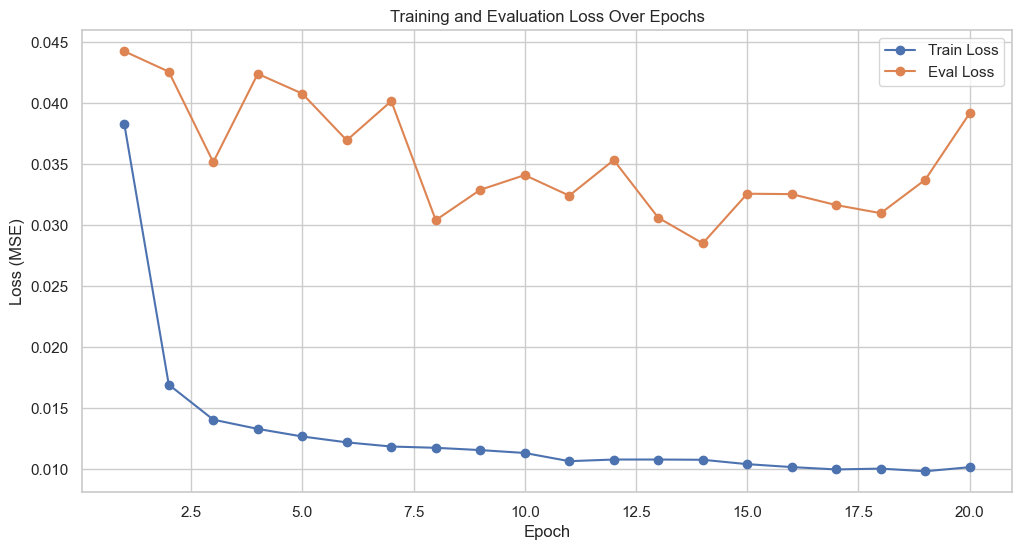

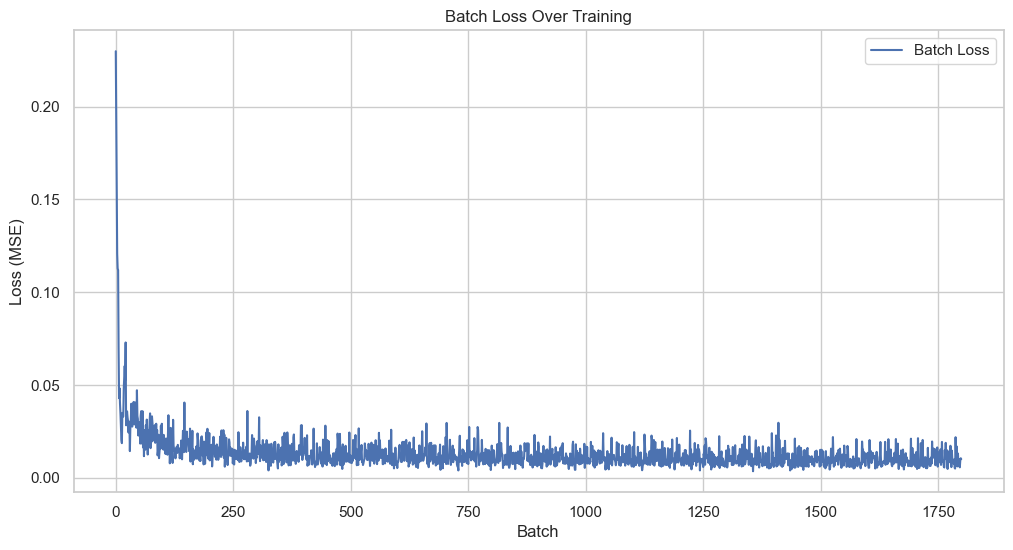

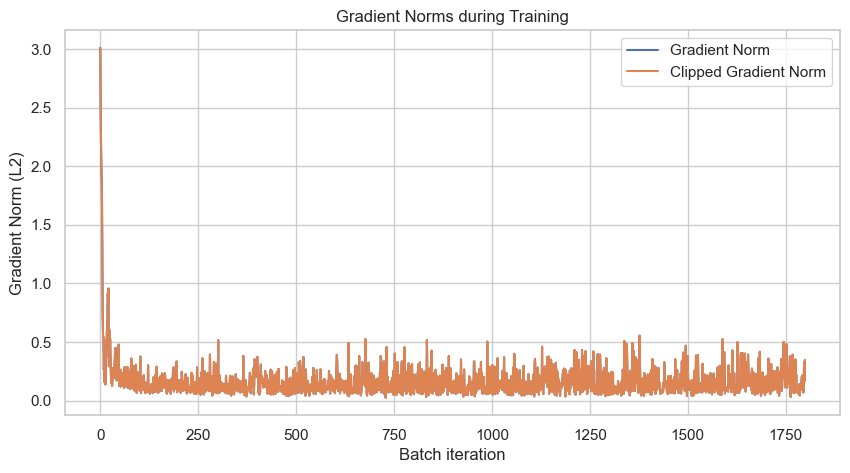

{'dataset': 'df_interpolated', 'dropped_vars': [''], 'imputation': 'linear interpolation', 'model': 'GRU', 'sequence_length': 7, 'scaler': 'MinMaxScaler', 'scaler_target': True, 'batch_size': 32, 'input_dim': 99, 'hidden_dim': 16, 'num_layers': 2, 'output_dim': 1, 'dropout': 0.3, 'num_epochs': 20, 'learning_rate': 0.001, 'train_loss': 0.010136366459644504, 'eval_loss': 0.0391737095227367, 'Features': ['id_num', 'mood_mean_tod', 'mood_max_tod', 'mood_min_tod', 'activity_max_tod', 'circumplex.valence_mean_tod', 'circumplex.valence_max_tod', 'circumplex.valence_min_tod', 'circumplex.arousal_mean_tod', 'circumplex.arousal_max_tod', 'circumplex.arousal_min_tod', 'circumplex.QUADRANT_tod_1', 'circumplex.QUADRANT_tod_2', 'circumplex.QUADRANT_tod_3', 'circumplex.QUADRANT_tod_4', 'change_mood_mean_tod', 'change_circumplex.valence_mean_tod', 'change_circumplex.arousal_mean_tod', 'mva7_mood_mean_tod', 'mva7_change_mood_mean_tod', 'mva7_circumplex.valence_mean_tod', 'mva7_change_circumplex.valence

In [116]:
# Hyperparameters
input_dim = len(train_dataset.features)  # e.g., 24
hidden_dim = 16             # Number of LSTM units
num_layers = 2
output_dim = 1                 # For regression (predicting a single value)
num_epochs = 20
learning_rate = 0.001
dropout = 0.3

# Initialize model, loss function, and optimizer
# model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model = SimpleRNNModel(input_dim, hidden_dim, num_layers, output_dim, dropout)
# model = GRUModel(input_dim, hidden_dim, num_layers, output_dim, dropout)

model = model.to(mps_device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # weight_decay=1e-5)

# Prepare lists to store loss values for plotting
train_epoch_losses = []
eval_epoch_losses = []
batch_losses = []
grad_norms = []  # list to store gradient norms for each batch
clipped_grad_norms = []  # list to store clipped gradient norms for each batch


# Training and evaluation loop
for epoch in range(num_epochs):
    model.train()
    train_loss_epoch = 0.0

    # --- Training ---
    for batch in train_loader:
        x_features, x_id, y = batch  # x_features: [batch, seq_length, input_dim]
        x_features = x_features.to(mps_device)
        x_id = x_id.to(mps_device)
        y = y.to(mps_device)  # y: [batch, output_dim]
        
        # Forward pass
        outputs = model(x_features)  # outputs shape: [batch, output_dim]
        loss = criterion(outputs.squeeze(), y)

        batch_losses.append(loss.item())
        
        # Backprop and optimization
        optimizer.zero_grad()
        loss.backward()

        # Compute total gradient norm
        total_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        grad_norms.append(total_norm)
        # Clip gradients
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # or another max_norm value

        # Compute clipped gradient norm
        clipped_grad_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                clipped_grad_norm += param_norm.item() ** 2
        clipped_grad_norm = clipped_grad_norm ** 0.5
        clipped_grad_norms.append(clipped_grad_norm)

        optimizer.step()
        
        train_loss_epoch += loss.item()
    
    avg_train_loss = train_loss_epoch / len(train_loader)
    train_epoch_losses.append(avg_train_loss)
    
    # --- Evaluation ---
    model.eval()
    eval_loss_epoch = 0.0
    with torch.no_grad():
        for batch in test_loader:
            x_features, x_id, y = batch
            x_features = x_features.to(mps_device)
            x_id = x_id.to(mps_device)
            y = y.to(mps_device)
            outputs = model(x_features)
            loss = criterion(outputs.squeeze(), y)
            eval_loss_epoch += loss.item()
    
    avg_eval_loss = eval_loss_epoch / len(test_loader)
    eval_epoch_losses.append(avg_eval_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_eval_loss:.4f}")

# Plot the training and evaluation loss curves
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs+1), train_epoch_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), eval_epoch_losses, label='Eval Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Evaluation Loss Over Epochs")
plt.legend()
plt.show()

# plot batch losses
plt.figure(figsize=(12, 6))
plt.plot(batch_losses, label='Batch Loss')
plt.xlabel("Batch")
plt.ylabel("Loss (MSE)")
plt.title("Batch Loss Over Training")
plt.legend()
plt.show()

# plot gradient norms
plt.figure(figsize=(10, 5))
plt.plot(grad_norms)
plt.plot(clipped_grad_norms)
plt.legend(["Gradient Norm", "Clipped Gradient Norm"])
plt.xlabel("Batch iteration")
plt.ylabel("Gradient Norm (L2)")
plt.title("Gradient Norms during Training")
plt.show()



# append the csv with hyperparameters and losses
hyperparameters = {
    "dataset": dataset_name,
    "dropped_vars": dropped_vars,
    "imputation": imputation,
    "model": "GRU",
    "sequence_length": seq_length,
    "scaler": SCALER_TYPE,
    "scaler_target": TRANSFORM_TARGET,
    "batch_size": batch_size,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "num_layers": num_layers,
    "output_dim": output_dim,
    "dropout": dropout,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "train_loss": train_epoch_losses[-1],
    "eval_loss": eval_epoch_losses[-1],
    "Features": train_dataset.features,
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
}
print(hyperparameters)
hyperparameters_df = pd.DataFrame([hyperparameters])
if not os.path.exists("tables/hyperparameters2.csv"):
    # create the csv with the hyperparameters
    hyperparameters_df.to_csv("tables/hyperparameters2.csv", index=False, header=True)
hyperparameters_df = pd.DataFrame([hyperparameters])
hyperparameters_df.to_csv("tables/hyperparameters2.csv", mode='a', header=False, index=False)


### Predict and plot function

In [119]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def predict_and_plot_simple(model, train_loader, test_loader, target_scaler=None):
    def get_predictions(loader):
        model.eval()
        predictions = []
        targets = []
        with torch.no_grad():
            for batch in loader:
                x, _, y = batch
                x = x.cpu()
                y = y.cpu()
                output = model(x)
                predictions.append(output.numpy())
                targets.append(y.numpy())
        predictions = np.concatenate(predictions)
        targets = np.concatenate(targets)
        
        if target_scaler is not None:
            predictions = target_scaler.inverse_transform(predictions)
            targets = target_scaler.inverse_transform(targets.reshape(-1, 1))

        return predictions.reshape(-1), targets.reshape(-1)

    model.to("cpu")
    y_pred_train, y_true_train = get_predictions(train_loader)
    y_pred_test, y_true_test = get_predictions(test_loader)

    def print_stats(y_true, y_pred, label=""):
        print(f"\n{label} Descriptive Statistics:")
        print(f"Predictions - Mean: {np.mean(y_pred):.2f}, Std: {np.std(y_pred):.2f}, Min: {np.min(y_pred):.2f}, Max: {np.max(y_pred):.2f}")
        print(f"Targets     - Mean: {np.mean(y_true):.2f}, Std: {np.std(y_true):.2f}, Min: {np.min(y_true):.2f}, Max: {np.max(y_true):.2f}")
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        print(f"{label} MAE: {mae:.3f}, MSE: {mse:.3f}, R2: {r2:.3f}")
        return mae, mse, r2

    # Print metrics
    print_stats(y_true_train, y_pred_train, "Train")
    print_stats(y_true_test, y_pred_test, "Test")

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    axes[0].plot(y_true_train, label="Real", alpha=0.7)
    axes[0].plot(y_pred_train, label="Predicted", alpha=0.7)
    axes[0].set_title("Train: Real vs Predicted")
    # axes[0].set_ylim([6, 9])
    axes[0].legend()

    axes[1].plot(y_true_test, label="Real", alpha=0.7)
    axes[1].plot(y_pred_test, label="Predicted", alpha=0.7)
    axes[1].set_title("Test: Real vs Predicted")
    # axes[1].set_ylim([6, 9])
    axes[1].legend()

    plt.xlabel("Time step")
    plt.tight_layout()
    plt.show()

### Plot predictions


Train Descriptive Statistics:
Predictions - Mean: 7.61, Std: 0.25, Min: 6.76, Max: 8.12
Targets     - Mean: 7.45, Std: 0.49, Min: 4.80, Max: 9.00
Train MAE: 0.317, MSE: 0.185, R2: 0.218

Test Descriptive Statistics:
Predictions - Mean: 7.53, Std: 0.28, Min: 6.77, Max: 8.11
Targets     - Mean: 7.02, Std: 0.75, Min: 4.80, Max: 9.00
Test MAE: 0.662, MSE: 0.691, R2: -0.218


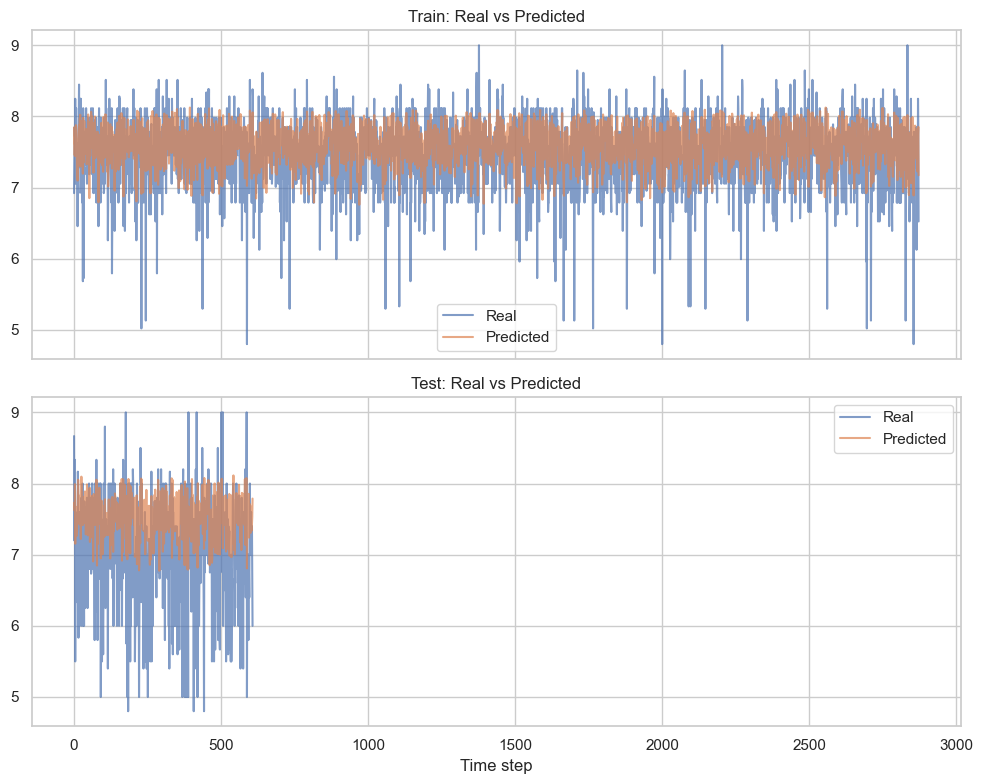

In [121]:

predict_and_plot_simple(model, train_loader, test_loader, target_scaler=scaler_target)
